### Import libs

In [2]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from sklearn.metrics import average_precision_score

from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.utils import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.losses import categorical_crossentropy

from keras.models import Model
from keras.utils import generic_utils
from keras.layers import Layer, InputSpec
from keras import initializers, regularizers



---



In [3]:
from model import *
from train import *
from input_utils import *



---



In [4]:
base_path = ''
test_path = 'validation/validation_annotation.txt'
test_base_path = 'validation' # Directory to save the test images

config_output_filename = os.path.join(base_path, 'model_vgg_config.pickle')

In [5]:
with open(config_output_filename, 'rb') as f_in:
	C = pickle.load(f_in)

# turn off any data augmentation at test time
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

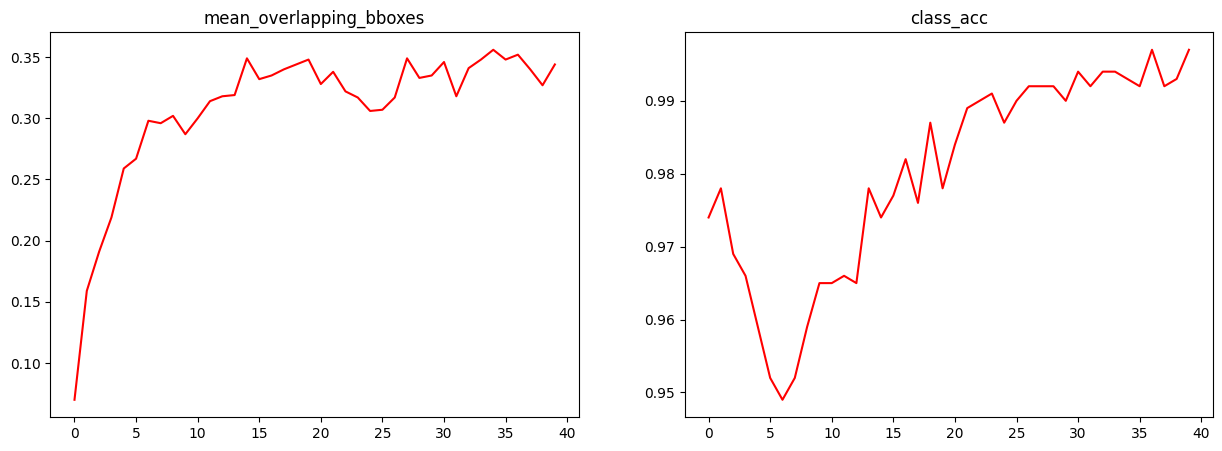

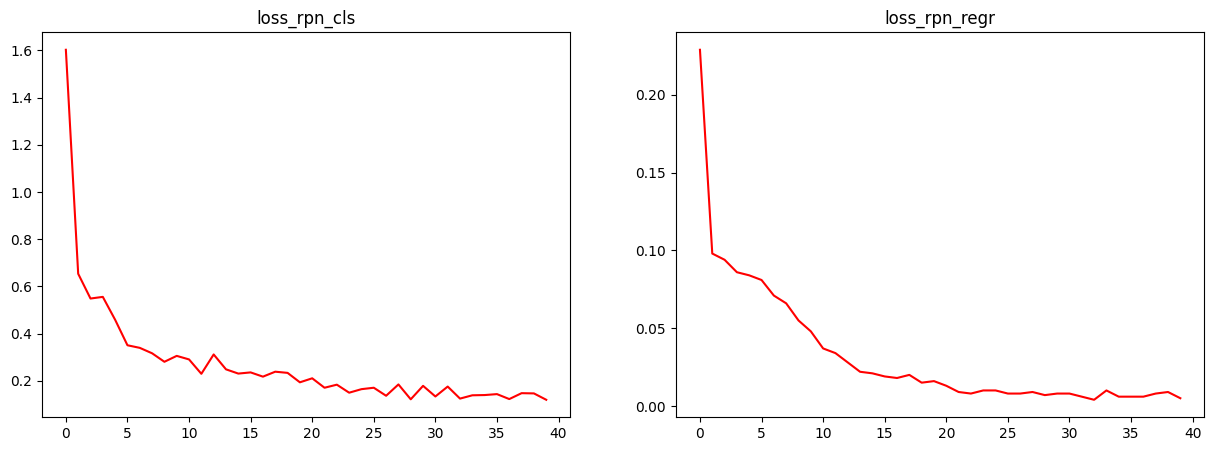

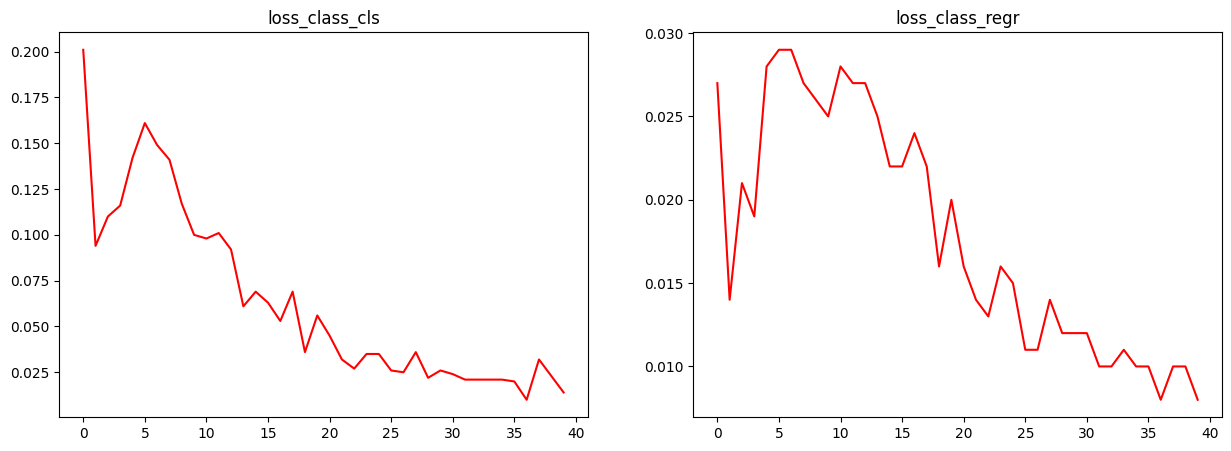

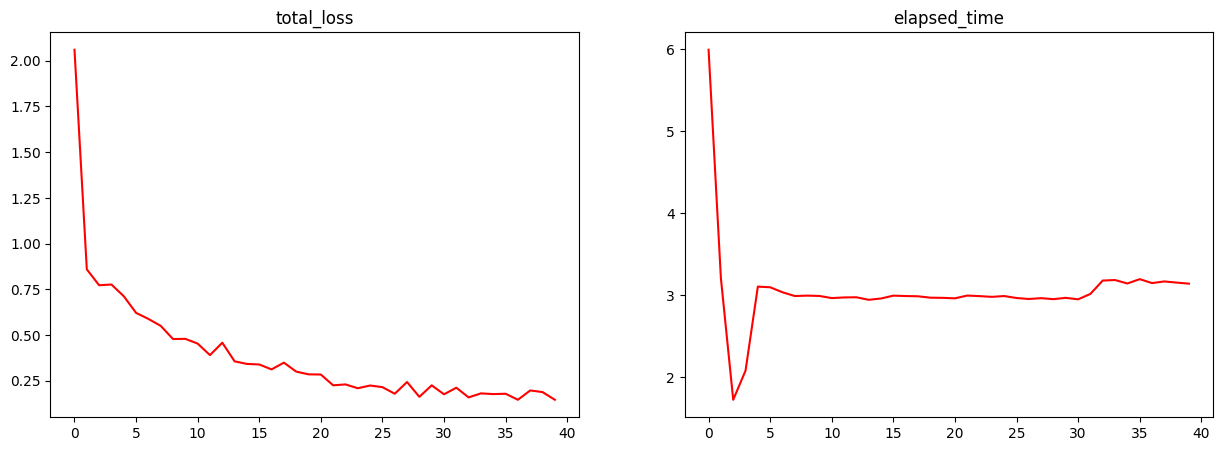

In [6]:
# Load the records
record_df = pd.read_csv(C.record_path)

r_epochs = len(record_df)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r')
plt.title('class_acc')

plt.show()

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r')
plt.title('loss_rpn_regr')
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
plt.title('loss_class_cls')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r')
plt.title('loss_class_regr')
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
plt.title('total_loss')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['elapsed_time'], 'r')
plt.title('elapsed_time')

plt.show()

# Test

In [7]:
def format_img_size(img, C):
    """ formats the image size based on config """
    img_min_side = float(C.im_size)
    (height,width,_) = img.shape

    if width <= height:
        ratio = img_min_side/width
        new_height = int(ratio * height)
        new_width = int(img_min_side)
    else:
        ratio = img_min_side/height
        new_width = int(ratio * width)
        new_height = int(img_min_side)
    img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    img = img.reshape(new_width, new_height, 1)
    return img, ratio	

def format_img_channels(img, C):
    """ formats the image channels based on config """
    x, y = img.shape
    img = img.reshape(x, y, 1)
    (rows,cols) = img.shape[:2]
    img = img.astype(np.float32)
    img[:, :, 0] -= C.img_channel_mean[0]
    img /= C.img_scaling_factor
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, axis=0)
    return img

def format_img(img, C):
    """ formats an image for model prediction based on config """
    img, ratio = format_img_size(img, C)
    img = format_img_channels(img, C)
    return img, ratio

# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):
    real_x1 = int(round(x1 // ratio))
    real_y1 = int(round(y1 // ratio))
    real_x2 = int(round(x2 // ratio))
    real_y2 = int(round(y2 // ratio))

    return (real_x1, real_y1, real_x2 ,real_y2)

In [8]:
num_features = 512

input_shape_img = (None, None, 1)
input_shape_features = (None, None, num_features)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

# define the base network (VGG here, can be Resnet50, Inception, etc)
shared_layers = nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = rpn_layer(shared_layers, num_anchors)

classifier = classifier_layer(feature_map_input, roi_input, C.num_rois, nb_classes=len(C.class_mapping))

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)

print('Loading weights from {}'.format(C.model_path))
model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

Loading weights from model/model_frcnn_vgg.hdf5


In [9]:
# Switch key value for class mapping
class_mapping = C.class_mapping
class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

{0: 'B', 2: 'bg', 1: 'M'}


In [10]:
# TODO load all images

test_imgs = os.listdir(test_base_path)

imgs_path = []
for i in range(12):
	idx = np.random.randint(len(test_imgs))
	imgs_path.append(test_imgs[idx])

all_imgs = []

classes = {}

In [11]:
# If the box classification value is less than this, we ignore this box
bbox_threshold = 0.7

for idx, img_name in enumerate(imgs_path):
    if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
        continue
    print(img_name)
    st = time.time()
    filepath = os.path.join(test_base_path, img_name)

    img = cv2.imread(filepath)

    X, ratio = format_img(img, C)
    
    X = np.transpose(X, (0, 2, 3, 1))

    # get output layer Y1, Y2 from the RPN and the feature maps F
    # Y1: y_rpn_cls
    # Y2: y_rpn_regr
    [Y1, Y2, F] = model_rpn.predict(X)

    # Get bboxes by applying NMS 
    # R.shape = (300, 4)
    R = rpn_to_roi(Y1, Y2, C, K.image_dim_ordering(), overlap_thresh=0.7)

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0]//C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0]//C.num_rois:
            #pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        # Calculate bboxes coordinates on resized image
        for ii in range(P_cls.shape[1]):
            # Ignore 'bg' class
            if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.2)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]

            # Calculate real coordinates on original image
            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

            cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),4)

            textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
            all_dets.append((key,100*new_probs[jk]))

            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
            textOrg = (real_x1, real_y1-0)

            cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 1)
            cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
            cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)

    print('Elapsed time = {}'.format(time.time() - st))
    print(all_dets)
    plt.figure(figsize=(10,10))
    plt.grid()
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()

#### Measure mAP

In [12]:
def get_map(pred, gt, f):
	T = {}
	P = {}
	fx, fy = f

	for bbox in gt:
		bbox['bbox_matched'] = False

	pred_probs = np.array([s['prob'] for s in pred])
	box_idx_sorted_by_prob = np.argsort(pred_probs)[::-1]

	for box_idx in box_idx_sorted_by_prob:
		pred_box = pred[box_idx]
		pred_class = pred_box['class']
		pred_x1 = pred_box['x1']
		pred_x2 = pred_box['x2']
		pred_y1 = pred_box['y1']
		pred_y2 = pred_box['y2']
		pred_prob = pred_box['prob']
		if pred_class not in P:
			P[pred_class] = []
			T[pred_class] = []
		P[pred_class].append(pred_prob)
		found_match = False

		for gt_box in gt:
			gt_class = gt_box['class']
			gt_x1 = gt_box['x1']/fx
			gt_x2 = gt_box['x2']/fx
			gt_y1 = gt_box['y1']/fy
			gt_y2 = gt_box['y2']/fy
			gt_seen = gt_box['bbox_matched']
			if gt_class != pred_class:
				continue
			if gt_seen:
				continue
			iou_map = iou((pred_x1, pred_y1, pred_x2, pred_y2), (gt_x1, gt_y1, gt_x2, gt_y2))
			if iou_map >= 0.5:
				found_match = True
				gt_box['bbox_matched'] = True
				break
			else:
				continue

		T[pred_class].append(int(found_match))

	for gt_box in gt:
		if not gt_box['bbox_matched']:# and not gt_box['difficult']:
			if gt_box['class'] not in P:
				P[gt_box['class']] = []
				T[gt_box['class']] = []

			T[gt_box['class']].append(1)
			P[gt_box['class']].append(0)

	#import pdb
	#pdb.set_trace()
	return T, P

In [13]:
def format_img_map(img, C):
    """Format image for mAP. Resize original image to C.im_size (300 in here)

    Args:
        img: cv2 image
        C: config

    Returns:
        img: Scaled and normalized image with expanding dimension
        fx: ratio for width scaling
        fy: ratio for height scaling
    """

    img_min_side = float(C.im_size)
    (height,width,_) = img.shape

    if width <= height:
        f = img_min_side/width
        new_height = int(f * height)
        new_width = int(img_min_side)
    else:
        f = img_min_side/height
        new_width = int(f * width)
        new_height = int(img_min_side)
    fx = width/float(new_width)
    fy = height/float(new_height)
    img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    img = img.reshape(new_width, new_height, 1)
    img = img.astype(np.float32)
    img[:, :, 0] -= C.img_channel_mean[0]
    img /= C.img_scaling_factor
    # Change img shape from (height, width, channel) to (channel, height, width)
    img = np.transpose(img, (2, 0, 1))
    # Expand one dimension at axis 0
    # img shape becames (1, channel, height, width)
    img = np.expand_dims(img, axis=0)
    return img, fx, fy

In [14]:
print(class_mapping)

{0: 'B', 2: 'bg', 1: 'M'}


In [15]:
# This might takes a while to parser the data
test_imgs, _, _ = get_data(test_path, test_base_path)

Parsing annotation file
idx=1
Found class name with special name bg. Will be treated as a background region (this is usually for hard negative mining).
reading validation\mdb011.pgm
idx=2
reading validation\mdb014.pgm
idx=3
reading validation\mdb015.pgm
idx=4
reading validation\mdb021.pgm
idx=5
reading validation\mdb022.pgm
idx=6
reading validation\mdb024.pgm
idx=7
reading validation\mdb027.pgm
idx=8
reading validation\mdb032.pgm
idx=9
reading validation\mdb033.pgm
idx=10
reading validation\mdb039.pgm
idx=11
reading validation\mdb042.pgm
idx=12
reading validation\mdb050.pgm
idx=13
reading validation\mdb057.pgm
idx=14
reading validation\mdb070.pgm
idx=15
reading validation\mdb077.pgm
idx=16
reading validation\mdb086.pgm
idx=17
reading validation\mdb087.pgm
idx=18
reading validation\mdb088.pgm
idx=19
reading validation\mdb096.pgm
idx=20
reading validation\mdb100.pgm
idx=21
reading validation\mdb107.pgm
idx=22
reading validation\mdb111.pgm
idx=23
reading validation\mdb124.pgm
idx=24
readi

In [16]:
T = {}
P = {}
mAPs = []
Y_pred = {}
for idx, img_data in enumerate(test_imgs):
    print('{}/{}'.format(idx,len(test_imgs)))
    st = time.time()
    filepath = img_data['filepath']

    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    x, y = img.shape
    img = img.reshape(x, y, 1)

    X, fx, fy = format_img_map(img, C)

    # Change X (img) shape from (1, channel, height, width) to (1, height, width, channel)
    X = np.transpose(X, (0, 2, 3, 1))

    # get the feature maps and output from the RPN
    [Y1, Y2, F] = model_rpn.predict(X)

    R = rpn_to_roi(Y1, Y2, C, K.image_data_format(), overlap_thresh=0.7) # NOTE changed from image_dim_ordering

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0] // C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois * jk:C.num_rois * (jk + 1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0] // C.num_rois:
            # pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0], C.num_rois, curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        # Calculate all classes' bboxes coordinates on resized image (300, 400)
        # Drop 'bg' classes bboxes
        for ii in range(P_cls.shape[1]):

            # If class name is 'bg', continue
            if np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            # Get class name
            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4 * cls_num:4 * (cls_num + 1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([16 * x, 16 * y, 16 * (x + w), 16 * (y + h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        # Apply non-max-suppression on final bboxes to get the output bounding boxe
        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk, :]
            det = {'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'class': key, 'prob': new_probs[jk]}
            all_dets.append(det)

    # Debug
    Y_pred[filepath] = all_dets
    print(f"all_dets f{all_dets}")
    # Debug
    print('Elapsed time = {}'.format(time.time() - st))
    t, p = get_map(all_dets, img_data['bboxes'], (fx, fy))
    for key in t.keys():
        if key not in T:
            T[key] = []
            P[key] = []
        T[key].extend(t[key])
        P[key].extend(p[key])
    all_aps = []
    for key in T.keys():
        ap = average_precision_score(T[key], P[key])
        print('{} AP: {}'.format(key, ap))
        all_aps.append(ap)
    print('mAP = {}'.format(np.mean(np.array(all_aps))))
    mAPs.append(np.mean(np.array(all_aps)))
    #print(T)
    #print(P)
    
print()
print('mean average precision:', np.mean(np.array(mAPs)))

0/64
1/1 [==============================] - 0s 18ms/step
all_dets f[{'x1': 160, 'x2': 208, 'y1': 0, 'y2': 48, 'class': 'M', 'prob': 0.9966828}, {'x1': 144, 'x2': 160, 'y1': 64, 'y2': 80, 'class': 'M', 'prob': 0.9956879}, {'x1': 128, 'x2': 144, 'y1': 96, 'y2': 112, 'class': 'M', 'prob': 0.7844977}, {'x1': 208, 'x2': 224, 'y1': 80, 'y2': 96, 'class': 'M', 'prob': 0.53115374}, {'x1': 208, 'x2': 224, 'y1': 96, 'y2': 112, 'class': 'M', 'prob': 0.49969465}, {'x1': 208, 'x2': 224, 'y1': 64, 'y2': 80, 'class': 'M', 'prob': 0.463265}, {'x1': 160, 'x2': 176, 'y1': 96, 'y2': 112, 'class': 'B', 'prob': 0.96765935}, {'x1': 176, 'x2': 192, 'y1': 176, 'y2': 192, 'class': 'B', 'prob': 0.7764703}]
Elapsed time = 6.888059854507446
M AP: -0.0
B AP: -0.0
bg AP: 1.0
mAP = 0.3333333333333333
1/64
1/1 [==============================] - ETA: 0s

C:\Users\pawel\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\pawel\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


1/1 [==============================] - 0s 19ms/step
all_dets f[{'x1': 96, 'x2': 112, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.9595397}, {'x1': 144, 'x2': 160, 'y1': 96, 'y2': 112, 'class': 'B', 'prob': 0.873967}, {'x1': 96, 'x2': 112, 'y1': 112, 'y2': 128, 'class': 'B', 'prob': 0.8447386}, {'x1': 128, 'x2': 144, 'y1': 112, 'y2': 128, 'class': 'B', 'prob': 0.5212202}, {'x1': 64, 'x2': 112, 'y1': 0, 'y2': 64, 'class': 'M', 'prob': 0.98013514}, {'x1': 64, 'x2': 128, 'y1': 80, 'y2': 144, 'class': 'M', 'prob': 0.97197896}, {'x1': 64, 'x2': 80, 'y1': 176, 'y2': 192, 'class': 'M', 'prob': 0.9639491}, {'x1': 48, 'x2': 112, 'y1': 0, 'y2': 32, 'class': 'M', 'prob': 0.9575946}]
Elapsed time = 4.1683032512664795
M AP: -0.0
B AP: -0.0
bg AP: 1.0
mAP = 0.3333333333333333
2/64
1/1 [==============================] - 0s 19ms/step


C:\Users\pawel\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\pawel\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


1/1 [==============================] - 0s 19ms/step
all_dets f[{'x1': 144, 'x2': 192, 'y1': 0, 'y2': 48, 'class': 'M', 'prob': 0.99666095}, {'x1': 112, 'x2': 128, 'y1': 96, 'y2': 112, 'class': 'M', 'prob': 0.9795638}, {'x1': 128, 'x2': 144, 'y1': 64, 'y2': 80, 'class': 'M', 'prob': 0.9542304}, {'x1': 192, 'x2': 208, 'y1': 96, 'y2': 112, 'class': 'B', 'prob': 0.9999286}, {'x1': 192, 'x2': 208, 'y1': 112, 'y2': 128, 'class': 'B', 'prob': 0.9999231}, {'x1': 192, 'x2': 208, 'y1': 80, 'y2': 96, 'class': 'B', 'prob': 0.9999161}, {'x1': 192, 'x2': 208, 'y1': 64, 'y2': 80, 'class': 'B', 'prob': 0.99987686}, {'x1': 192, 'x2': 208, 'y1': 48, 'y2': 64, 'class': 'B', 'prob': 0.99525034}, {'x1': 144, 'x2': 160, 'y1': 96, 'y2': 112, 'class': 'B', 'prob': 0.93754095}, {'x1': 160, 'x2': 176, 'y1': 176, 'y2': 192, 'class': 'B', 'prob': 0.9320186}, {'x1': 192, 'x2': 208, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.8382325}]
Elapsed time = 5.050461530685425
M AP: -0.0
B AP: 0.06666666666666667
bg AP: 1

C:\Users\pawel\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


1/1 [==============================] - 0s 18ms/step
all_dets f[{'x1': 144, 'x2': 160, 'y1': 128, 'y2': 144, 'class': 'M', 'prob': 0.86006325}, {'x1': 208, 'x2': 224, 'y1': 64, 'y2': 80, 'class': 'M', 'prob': 0.74393225}, {'x1': 128, 'x2': 144, 'y1': 144, 'y2': 160, 'class': 'M', 'prob': 0.6978718}, {'x1': 208, 'x2': 224, 'y1': 80, 'y2': 96, 'class': 'M', 'prob': 0.56879634}, {'x1': 208, 'x2': 224, 'y1': 96, 'y2': 112, 'class': 'M', 'prob': 0.5518269}, {'x1': 208, 'x2': 224, 'y1': 112, 'y2': 128, 'class': 'M', 'prob': 0.4963228}, {'x1': 208, 'x2': 224, 'y1': 160, 'y2': 176, 'class': 'M', 'prob': 0.46368834}, {'x1': 208, 'x2': 224, 'y1': 144, 'y2': 160, 'class': 'M', 'prob': 0.44640747}, {'x1': 160, 'x2': 176, 'y1': 160, 'y2': 176, 'class': 'B', 'prob': 0.99938333}, {'x1': 112, 'x2': 176, 'y1': 144, 'y2': 208, 'class': 'B', 'prob': 0.9986273}, {'x1': 160, 'x2': 176, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.92700034}, {'x1': 208, 'x2': 224, 'y1': 128, 'y2': 144, 'class': 'B', 'prob':

C:\Users\pawel\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


1/1 [==============================] - 0s 17ms/step
all_dets f[{'x1': 64, 'x2': 80, 'y1': 144, 'y2': 160, 'class': 'M', 'prob': 0.9939383}, {'x1': 64, 'x2': 80, 'y1': 112, 'y2': 128, 'class': 'M', 'prob': 0.99392587}, {'x1': 64, 'x2': 80, 'y1': 128, 'y2': 144, 'class': 'M', 'prob': 0.9937045}, {'x1': 64, 'x2': 80, 'y1': 96, 'y2': 112, 'class': 'M', 'prob': 0.9926065}, {'x1': 64, 'x2': 80, 'y1': 160, 'y2': 176, 'class': 'M', 'prob': 0.99110526}, {'x1': 64, 'x2': 80, 'y1': 80, 'y2': 96, 'class': 'M', 'prob': 0.9880884}, {'x1': 64, 'x2': 80, 'y1': 64, 'y2': 80, 'class': 'M', 'prob': 0.9733931}, {'x1': 64, 'x2': 80, 'y1': 176, 'y2': 192, 'class': 'M', 'prob': 0.92195344}, {'x1': 64, 'x2': 128, 'y1': 0, 'y2': 32, 'class': 'M', 'prob': 0.6834539}, {'x1': 160, 'x2': 176, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.8270079}]
Elapsed time = 4.7573792934417725
M AP: -0.0
B AP: 0.09523809523809523
bg AP: 1.0
mAP = 0.3650793650793651
5/64
1/1 [==============================] - 0s 20ms/step


C:\Users\pawel\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


1/1 [==============================] - 0s 20ms/step
all_dets f[{'x1': 64, 'x2': 112, 'y1': 0, 'y2': 64, 'class': 'M', 'prob': 0.99380916}, {'x1': 48, 'x2': 112, 'y1': 0, 'y2': 32, 'class': 'M', 'prob': 0.97223973}, {'x1': 64, 'x2': 128, 'y1': 96, 'y2': 160, 'class': 'M', 'prob': 0.83149886}]
Elapsed time = 3.975574493408203
M AP: -0.0
B AP: 0.09523809523809523
bg AP: 1.0
mAP = 0.3650793650793651
6/64
1/1 [==============================] - 0s 18ms/step


C:\Users\pawel\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


1/1 [==============================] - 0s 19ms/step
all_dets f[]
Elapsed time = 4.714122772216797
M AP: -0.0
B AP: 0.09523809523809523
bg AP: 1.0
mAP = 0.3650793650793651
7/64
1/1 [==============================] - 0s 18ms/step


C:\Users\pawel\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


1/1 [==============================] - 0s 19ms/step
all_dets f[{'x1': 176, 'x2': 192, 'y1': 112, 'y2': 128, 'class': 'B', 'prob': 0.98749894}, {'x1': 96, 'x2': 112, 'y1': 112, 'y2': 128, 'class': 'B', 'prob': 0.93175244}, {'x1': 192, 'x2': 208, 'y1': 144, 'y2': 160, 'class': 'B', 'prob': 0.88471663}, {'x1': 160, 'x2': 176, 'y1': 208, 'y2': 224, 'class': 'B', 'prob': 0.76723546}, {'x1': 144, 'x2': 160, 'y1': 208, 'y2': 224, 'class': 'B', 'prob': 0.6175263}, {'x1': 128, 'x2': 144, 'y1': 112, 'y2': 128, 'class': 'M', 'prob': 0.99968827}, {'x1': 64, 'x2': 80, 'y1': 96, 'y2': 112, 'class': 'M', 'prob': 0.9594215}, {'x1': 64, 'x2': 128, 'y1': 64, 'y2': 128, 'class': 'M', 'prob': 0.85642576}]
Elapsed time = 4.28320050239563
M AP: -0.0
B AP: 0.1111111111111111
bg AP: 1.0
mAP = 0.3703703703703704
8/64
1/1 [==============================] - ETA: 0s

C:\Users\pawel\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


1/1 [==============================] - 0s 19ms/step
all_dets f[{'x1': 176, 'x2': 192, 'y1': 144, 'y2': 160, 'class': 'B', 'prob': 0.99380165}, {'x1': 176, 'x2': 192, 'y1': 160, 'y2': 176, 'class': 'B', 'prob': 0.9535803}]
Elapsed time = 4.780014514923096
M AP: -0.0
B AP: 0.10344827586206896
bg AP: 1.0
mAP = 0.367816091954023
9/64
1/1 [==============================] - ETA: 0s

C:\Users\pawel\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


1/1 [==============================] - 0s 19ms/step
all_dets f[{'x1': 176, 'x2': 192, 'y1': 96, 'y2': 112, 'class': 'B', 'prob': 0.998412}, {'x1': 176, 'x2': 192, 'y1': 112, 'y2': 128, 'class': 'B', 'prob': 0.9982181}, {'x1': 176, 'x2': 192, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.95978236}, {'x1': 176, 'x2': 192, 'y1': 80, 'y2': 96, 'class': 'B', 'prob': 0.9475029}]
Elapsed time = 4.222529172897339
M AP: -0.0
B AP: 0.09090909090909091
bg AP: 1.0
mAP = 0.3636363636363636
10/64
1/1 [==============================] - ETA: 0s

C:\Users\pawel\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


1/1 [==============================] - 0s 18ms/step
all_dets f[{'x1': 64, 'x2': 112, 'y1': 0, 'y2': 64, 'class': 'M', 'prob': 0.98724234}, {'x1': 96, 'x2': 144, 'y1': 192, 'y2': 240, 'class': 'M', 'prob': 0.95775574}, {'x1': 64, 'x2': 112, 'y1': 0, 'y2': 32, 'class': 'M', 'prob': 0.9530053}, {'x1': 96, 'x2': 144, 'y1': 176, 'y2': 224, 'class': 'M', 'prob': 0.7157144}]
Elapsed time = 5.615694522857666
M AP: -0.0
B AP: 0.09090909090909091
bg AP: 1.0
mAP = 0.3636363636363636
11/64
1/1 [==============================] - 0s 18ms/step


C:\Users\pawel\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


1/1 [==============================] - 0s 22ms/step
all_dets f[{'x1': 176, 'x2': 192, 'y1': 96, 'y2': 112, 'class': 'B', 'prob': 0.9996253}, {'x1': 96, 'x2': 112, 'y1': 96, 'y2': 112, 'class': 'B', 'prob': 0.98671675}, {'x1': 96, 'x2': 112, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.9809699}, {'x1': 192, 'x2': 208, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.7762687}, {'x1': 112, 'x2': 128, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.64917}, {'x1': 160, 'x2': 176, 'y1': 80, 'y2': 96, 'class': 'B', 'prob': 0.5076831}, {'x1': 128, 'x2': 144, 'y1': 96, 'y2': 112, 'class': 'M', 'prob': 0.99978894}, {'x1': 112, 'x2': 128, 'y1': 80, 'y2': 96, 'class': 'M', 'prob': 0.9758538}, {'x1': 64, 'x2': 80, 'y1': 80, 'y2': 96, 'class': 'M', 'prob': 0.95923764}, {'x1': 64, 'x2': 128, 'y1': 48, 'y2': 112, 'class': 'M', 'prob': 0.9129917}, {'x1': 64, 'x2': 80, 'y1': 192, 'y2': 208, 'class': 'M', 'prob': 0.81537247}]
Elapsed time = 4.03832745552063
M AP: -0.0
B AP: 0.07692307692307693
bg AP: 1.0
mAP

C:\Users\pawel\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


1/1 [==============================] - 0s 18ms/step
all_dets f[{'x1': 112, 'x2': 176, 'y1': 112, 'y2': 176, 'class': 'B', 'prob': 0.96424884}, {'x1': 144, 'x2': 160, 'y1': 144, 'y2': 160, 'class': 'B', 'prob': 0.95098037}, {'x1': 112, 'x2': 176, 'y1': 144, 'y2': 208, 'class': 'B', 'prob': 0.83256346}, {'x1': 192, 'x2': 208, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.8236585}, {'x1': 160, 'x2': 176, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.7072971}, {'x1': 144, 'x2': 176, 'y1': 144, 'y2': 176, 'class': 'B', 'prob': 0.5554092}, {'x1': 208, 'x2': 224, 'y1': 160, 'y2': 176, 'class': 'B', 'prob': 0.48453867}, {'x1': 112, 'x2': 128, 'y1': 144, 'y2': 160, 'class': 'M', 'prob': 0.94015044}, {'x1': 176, 'x2': 224, 'y1': 0, 'y2': 48, 'class': 'M', 'prob': 0.8508126}, {'x1': 112, 'x2': 128, 'y1': 128, 'y2': 144, 'class': 'M', 'prob': 0.77006745}, {'x1': 208, 'x2': 224, 'y1': 80, 'y2': 96, 'class': 'M', 'prob': 0.5414875}, {'x1': 208, 'x2': 224, 'y1': 128, 'y2': 144, 'class': 'M', 'prob': 

C:\Users\pawel\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


1/1 [==============================] - 0s 18ms/step
all_dets f[{'x1': 96, 'x2': 112, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.9525986}, {'x1': 96, 'x2': 112, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.9026884}, {'x1': 160, 'x2': 176, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.8173699}, {'x1': 128, 'x2': 144, 'y1': 144, 'y2': 160, 'class': 'M', 'prob': 0.9635931}, {'x1': 64, 'x2': 128, 'y1': 80, 'y2': 144, 'class': 'M', 'prob': 0.9265353}, {'x1': 64, 'x2': 80, 'y1': 176, 'y2': 192, 'class': 'M', 'prob': 0.92060876}]
Elapsed time = 5.053008794784546
M AP: -0.0
B AP: 0.061224489795918366
bg AP: 1.0
mAP = 0.35374149659863946
14/64
1/1 [==============================] - ETA: 0s

C:\Users\pawel\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


1/1 [==============================] - 0s 18ms/step
all_dets f[{'x1': 176, 'x2': 192, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.9469784}, {'x1': 192, 'x2': 208, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.9092616}, {'x1': 160, 'x2': 176, 'y1': 64, 'y2': 80, 'class': 'B', 'prob': 0.8814977}, {'x1': 112, 'x2': 176, 'y1': 112, 'y2': 176, 'class': 'B', 'prob': 0.8651519}, {'x1': 144, 'x2': 176, 'y1': 128, 'y2': 160, 'class': 'B', 'prob': 0.6202956}, {'x1': 208, 'x2': 224, 'y1': 160, 'y2': 176, 'class': 'B', 'prob': 0.58414596}, {'x1': 208, 'x2': 224, 'y1': 144, 'y2': 160, 'class': 'B', 'prob': 0.55316186}, {'x1': 144, 'x2': 160, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.53579426}, {'x1': 208, 'x2': 224, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.50476843}, {'x1': 208, 'x2': 224, 'y1': 192, 'y2': 208, 'class': 'B', 'prob': 0.46692213}, {'x1': 208, 'x2': 224, 'y1': 64, 'y2': 80, 'class': 'M', 'prob': 0.61659807}, {'x1': 208, 'x2': 224, 'y1': 80, 'y2': 96, 'class': 'M', 'prob': 0

C:\Users\pawel\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


1/1 [==============================] - 0s 18ms/step
all_dets f[{'x1': 64, 'x2': 80, 'y1': 96, 'y2': 112, 'class': 'M', 'prob': 0.9939896}, {'x1': 64, 'x2': 80, 'y1': 80, 'y2': 96, 'class': 'M', 'prob': 0.993891}, {'x1': 64, 'x2': 80, 'y1': 112, 'y2': 128, 'class': 'M', 'prob': 0.99378467}, {'x1': 64, 'x2': 80, 'y1': 144, 'y2': 160, 'class': 'M', 'prob': 0.993779}, {'x1': 64, 'x2': 80, 'y1': 128, 'y2': 144, 'class': 'M', 'prob': 0.9937662}, {'x1': 64, 'x2': 80, 'y1': 160, 'y2': 176, 'class': 'M', 'prob': 0.9936144}, {'x1': 64, 'x2': 80, 'y1': 64, 'y2': 80, 'class': 'M', 'prob': 0.99234056}, {'x1': 64, 'x2': 128, 'y1': 0, 'y2': 48, 'class': 'M', 'prob': 0.9869603}, {'x1': 64, 'x2': 80, 'y1': 176, 'y2': 192, 'class': 'M', 'prob': 0.98562837}, {'x1': 112, 'x2': 160, 'y1': 176, 'y2': 224, 'class': 'M', 'prob': 0.93705237}, {'x1': 64, 'x2': 80, 'y1': 192, 'y2': 208, 'class': 'M', 'prob': 0.7112328}, {'x1': 112, 'x2': 160, 'y1': 192, 'y2': 240, 'class': 'M', 'prob': 0.6293637}, {'x1': 128, 'x

C:\Users\pawel\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


1/1 [==============================] - 0s 18ms/step
all_dets f[{'x1': 192, 'x2': 208, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.9999696}, {'x1': 192, 'x2': 208, 'y1': 144, 'y2': 160, 'class': 'B', 'prob': 0.9999621}, {'x1': 192, 'x2': 208, 'y1': 160, 'y2': 176, 'class': 'B', 'prob': 0.99987984}, {'x1': 192, 'x2': 208, 'y1': 112, 'y2': 128, 'class': 'B', 'prob': 0.99987483}, {'x1': 192, 'x2': 208, 'y1': 176, 'y2': 192, 'class': 'B', 'prob': 0.99931645}, {'x1': 192, 'x2': 208, 'y1': 96, 'y2': 112, 'class': 'B', 'prob': 0.7878694}, {'x1': 192, 'x2': 208, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.5007816}, {'x1': 128, 'x2': 144, 'y1': 144, 'y2': 160, 'class': 'M', 'prob': 0.80048263}]
Elapsed time = 4.957377910614014
M AP: -0.0
B AP: 0.04477611940298507
bg AP: 1.0
mAP = 0.34825870646766166
17/64
1/1 [==============================] - ETA: 0s

C:\Users\pawel\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


1/1 [==============================] - 0s 19ms/step
all_dets f[{'x1': 112, 'x2': 128, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.51756155}, {'x1': 144, 'x2': 160, 'y1': 160, 'y2': 176, 'class': 'B', 'prob': 0.4995351}, {'x1': 64, 'x2': 80, 'y1': 192, 'y2': 208, 'class': 'M', 'prob': 0.9935314}, {'x1': 64, 'x2': 80, 'y1': 176, 'y2': 192, 'class': 'M', 'prob': 0.9904343}, {'x1': 64, 'x2': 80, 'y1': 208, 'y2': 224, 'class': 'M', 'prob': 0.9896203}, {'x1': 64, 'x2': 80, 'y1': 160, 'y2': 176, 'class': 'M', 'prob': 0.9750378}, {'x1': 64, 'x2': 80, 'y1': 144, 'y2': 160, 'class': 'M', 'prob': 0.78855324}, {'x1': 112, 'x2': 160, 'y1': 160, 'y2': 208, 'class': 'M', 'prob': 0.5995879}, {'x1': 64, 'x2': 128, 'y1': 0, 'y2': 32, 'class': 'M', 'prob': 0.5630065}]
Elapsed time = 3.9940900802612305
M AP: -0.0
B AP: 0.043478260869565216
bg AP: 1.0
mAP = 0.34782608695652173
18/64
1/1 [==============================] - 0s 17ms/step


C:\Users\pawel\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


1/1 [==============================] - 0s 20ms/step
all_dets f[{'x1': 64, 'x2': 80, 'y1': 160, 'y2': 176, 'class': 'M', 'prob': 0.82574433}, {'x1': 64, 'x2': 128, 'y1': 160, 'y2': 224, 'class': 'M', 'prob': 0.66148335}, {'x1': 64, 'x2': 80, 'y1': 208, 'y2': 224, 'class': 'M', 'prob': 0.5206465}, {'x1': 48, 'x2': 112, 'y1': 0, 'y2': 32, 'class': 'M', 'prob': 0.5192746}, {'x1': 128, 'x2': 144, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.9981951}, {'x1': 144, 'x2': 160, 'y1': 176, 'y2': 192, 'class': 'B', 'prob': 0.9191143}]
Elapsed time = 5.523146629333496
M AP: -0.0
B AP: 0.04225352112676056
bg AP: 1.0
mAP = 0.3474178403755868
19/64
1/1 [==============================] - 0s 19ms/step


C:\Users\pawel\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


1/1 [==============================] - 0s 20ms/step
all_dets f[{'x1': 112, 'x2': 128, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.976154}, {'x1': 160, 'x2': 176, 'y1': 144, 'y2': 160, 'class': 'B', 'prob': 0.8319383}, {'x1': 64, 'x2': 80, 'y1': 128, 'y2': 144, 'class': 'M', 'prob': 0.9941036}, {'x1': 64, 'x2': 80, 'y1': 176, 'y2': 192, 'class': 'M', 'prob': 0.9940982}, {'x1': 64, 'x2': 80, 'y1': 144, 'y2': 160, 'class': 'M', 'prob': 0.9940063}, {'x1': 64, 'x2': 80, 'y1': 160, 'y2': 176, 'class': 'M', 'prob': 0.99393165}, {'x1': 64, 'x2': 80, 'y1': 112, 'y2': 128, 'class': 'M', 'prob': 0.99376196}, {'x1': 64, 'x2': 80, 'y1': 96, 'y2': 112, 'class': 'M', 'prob': 0.99212193}, {'x1': 64, 'x2': 80, 'y1': 80, 'y2': 96, 'class': 'M', 'prob': 0.98952776}, {'x1': 64, 'x2': 80, 'y1': 192, 'y2': 208, 'class': 'M', 'prob': 0.9886342}, {'x1': 64, 'x2': 80, 'y1': 64, 'y2': 80, 'class': 'M', 'prob': 0.9833788}, {'x1': 64, 'x2': 128, 'y1': 0, 'y2': 32, 'class': 'M', 'prob': 0.95892996}, {'x1': 80, '

C:\Users\pawel\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


1/1 [==============================] - 0s 19ms/step
all_dets f[{'x1': 128, 'x2': 144, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.9903037}, {'x1': 80, 'x2': 144, 'y1': 128, 'y2': 192, 'class': 'B', 'prob': 0.97909355}, {'x1': 96, 'x2': 160, 'y1': 144, 'y2': 208, 'class': 'B', 'prob': 0.9246246}, {'x1': 208, 'x2': 224, 'y1': 96, 'y2': 112, 'class': 'B', 'prob': 0.70198876}, {'x1': 208, 'x2': 224, 'y1': 160, 'y2': 176, 'class': 'B', 'prob': 0.3953448}, {'x1': 96, 'x2': 112, 'y1': 144, 'y2': 160, 'class': 'M', 'prob': 0.9943404}, {'x1': 96, 'x2': 160, 'y1': 112, 'y2': 176, 'class': 'M', 'prob': 0.9754657}, {'x1': 112, 'x2': 128, 'y1': 128, 'y2': 144, 'class': 'M', 'prob': 0.79496634}, {'x1': 96, 'x2': 112, 'y1': 160, 'y2': 176, 'class': 'M', 'prob': 0.6497758}, {'x1': 208, 'x2': 224, 'y1': 128, 'y2': 144, 'class': 'M', 'prob': 0.632141}]
Elapsed time = 4.126744031906128
M AP: -0.0
B AP: 0.05063291139240506
bg AP: 1.0
mAP = 0.350210970464135
21/64
1/1 [==============================] - 0

C:\Users\pawel\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


1/1 [==============================] - 0s 19ms/step
all_dets f[{'x1': 112, 'x2': 176, 'y1': 112, 'y2': 176, 'class': 'B', 'prob': 0.9998685}, {'x1': 144, 'x2': 160, 'y1': 144, 'y2': 160, 'class': 'B', 'prob': 0.9125582}, {'x1': 96, 'x2': 160, 'y1': 128, 'y2': 192, 'class': 'B', 'prob': 0.7201813}, {'x1': 208, 'x2': 224, 'y1': 96, 'y2': 112, 'class': 'B', 'prob': 0.47119725}, {'x1': 176, 'x2': 224, 'y1': 0, 'y2': 48, 'class': 'M', 'prob': 0.6636064}, {'x1': 208, 'x2': 224, 'y1': 128, 'y2': 144, 'class': 'M', 'prob': 0.4983708}, {'x1': 208, 'x2': 224, 'y1': 80, 'y2': 96, 'class': 'M', 'prob': 0.4676151}]
Elapsed time = 4.007961988449097
M AP: 0.009523809523809525
B AP: 0.04819277108433735
bg AP: 1.0
mAP = 0.3525721935360489
22/64
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
all_dets f[{'x1': 64, 'x2': 96, 'y1': 224, 'y2': 256, 'class': 'B', 'prob': 0.9892603}, {'x1': 64, 'x2': 80, 'y1': 160, 'y2': 176, 'class': 'M', 'prob': 0.9931932}, {'x1': 64, 'x2': 80, 'y1': 176, 'y2': 192, 'class': 'M', 'prob': 0.9928808}, {'x1': 64, 'x2': 80, 'y1': 144, 'y2': 160, 'class': 'M', 'prob': 0.9920513}, {'x1': 64, 'x2': 80, 'y1': 192, 'y2': 208, 'class': 'M', 'prob': 0.99058235}, {'x1': 64, 'x2': 80, 'y1': 128, 'y2': 144, 'class': 'M', 'prob': 0.9829412}, {'x1': 112, 'x2': 160, 'y1': 192, 'y2': 240, 'class': 'M', 'prob': 0.9325528}, {'x1': 64, 'x2': 80, 'y1': 112, 'y2': 128, 'class': 'M', 'prob': 0.9180112}, {'x1': 64, 'x2': 128, 'y1': 0, 'y2': 32, 'class': 'M', 'prob': 0.7251119}, {'x1': 112, 'x2': 160, 'y1': 208, 'y2': 256, 'class': 'M', 'prob': 0.5177171}, {'x1': 64, 'x2': 80, 'y1': 96, 'y2': 112, 'class': 'M', 'prob': 0.5066}, {'x1': 64, 'x2': 80, 'y1': 208, 'y2': 224, 'class': 'M', 'prob': 0.49988863}]
Elapsed time 

1/1 [==============================] - 0s 19ms/step
all_dets f[{'x1': 112, 'x2': 192, 'y1': 128, 'y2': 208, 'class': 'B', 'prob': 0.9988544}, {'x1': 32, 'x2': 48, 'y1': 64, 'y2': 80, 'class': 'B', 'prob': 0.98863506}, {'x1': 32, 'x2': 48, 'y1': 80, 'y2': 96, 'class': 'B', 'prob': 0.98828924}, {'x1': 32, 'x2': 48, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.98769706}, {'x1': 32, 'x2': 48, 'y1': 112, 'y2': 128, 'class': 'B', 'prob': 0.9871351}, {'x1': 32, 'x2': 48, 'y1': 96, 'y2': 112, 'class': 'B', 'prob': 0.9868102}, {'x1': 32, 'x2': 48, 'y1': 144, 'y2': 160, 'class': 'B', 'prob': 0.98558307}, {'x1': 32, 'x2': 48, 'y1': 160, 'y2': 176, 'class': 'B', 'prob': 0.978203}, {'x1': 128, 'x2': 192, 'y1': 112, 'y2': 176, 'class': 'B', 'prob': 0.92548436}, {'x1': 160, 'x2': 176, 'y1': 144, 'y2': 160, 'class': 'B', 'prob': 0.8807574}, {'x1': 144, 'x2': 208, 'y1': 144, 'y2': 208, 'class': 'B', 'prob': 0.72952354}, {'x1': 112, 'x2': 208, 'y1': 96, 'y2': 144, 'class': 'B', 'prob': 0.72094333}, {'x

1/1 [==============================] - 0s 17ms/step
all_dets f[{'x1': 80, 'x2': 96, 'y1': 128, 'y2': 144, 'class': 'M', 'prob': 0.90827334}, {'x1': 16, 'x2': 80, 'y1': 64, 'y2': 128, 'class': 'M', 'prob': 0.8647419}, {'x1': 80, 'x2': 96, 'y1': 176, 'y2': 192, 'class': 'M', 'prob': 0.85996556}, {'x1': 80, 'x2': 96, 'y1': 192, 'y2': 208, 'class': 'M', 'prob': 0.8325845}, {'x1': 80, 'x2': 96, 'y1': 112, 'y2': 128, 'class': 'M', 'prob': 0.82633007}, {'x1': 80, 'x2': 96, 'y1': 144, 'y2': 160, 'class': 'M', 'prob': 0.6693017}, {'x1': 80, 'x2': 96, 'y1': 160, 'y2': 176, 'class': 'M', 'prob': 0.56426597}, {'x1': 176, 'x2': 192, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.9969471}]
Elapsed time = 3.9463071823120117
M AP: 0.015384615384615385
B AP: 0.04807692307692308
bg AP: 1.0
mAP = 0.3544871794871795
27/64
1/1 [==============================] - 0s 20ms/step
all_dets f[{'x1': 0, 'x2': 64, 'y1': 176, 'y2': 240, 'class': 'M', 'prob': 0.78363055}, {'x1': 0, 'x2': 64, 'y1': 128, 'y2': 256, 'clas

1/1 [==============================] - 0s 19ms/step
all_dets f[{'x1': 64, 'x2': 80, 'y1': 64, 'y2': 80, 'class': 'M', 'prob': 0.9937138}, {'x1': 64, 'x2': 80, 'y1': 160, 'y2': 176, 'class': 'M', 'prob': 0.9936946}, {'x1': 64, 'x2': 80, 'y1': 80, 'y2': 96, 'class': 'M', 'prob': 0.993551}, {'x1': 64, 'x2': 80, 'y1': 96, 'y2': 112, 'class': 'M', 'prob': 0.99354446}, {'x1': 64, 'x2': 80, 'y1': 112, 'y2': 128, 'class': 'M', 'prob': 0.99347866}, {'x1': 64, 'x2': 80, 'y1': 144, 'y2': 160, 'class': 'M', 'prob': 0.99347717}, {'x1': 64, 'x2': 80, 'y1': 128, 'y2': 144, 'class': 'M', 'prob': 0.99343973}, {'x1': 64, 'x2': 80, 'y1': 176, 'y2': 192, 'class': 'M', 'prob': 0.9915454}, {'x1': 80, 'x2': 128, 'y1': 0, 'y2': 64, 'class': 'M', 'prob': 0.9901502}, {'x1': 80, 'x2': 128, 'y1': 0, 'y2': 32, 'class': 'M', 'prob': 0.9883498}, {'x1': 160, 'x2': 176, 'y1': 96, 'y2': 112, 'class': 'M', 'prob': 0.5920344}, {'x1': 160, 'x2': 176, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.6866645}]
Elapsed time = 4

1/1 [==============================] - 0s 19ms/step
all_dets f[{'x1': 112, 'x2': 128, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.99173695}, {'x1': 128, 'x2': 144, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.9891851}, {'x1': 96, 'x2': 112, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.9794129}, {'x1': 176, 'x2': 192, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.6734836}, {'x1': 128, 'x2': 144, 'y1': 128, 'y2': 144, 'class': 'M', 'prob': 0.9746518}, {'x1': 64, 'x2': 128, 'y1': 64, 'y2': 128, 'class': 'M', 'prob': 0.9559849}, {'x1': 64, 'x2': 80, 'y1': 176, 'y2': 192, 'class': 'M', 'prob': 0.9248657}, {'x1': 64, 'x2': 128, 'y1': 0, 'y2': 48, 'class': 'M', 'prob': 0.92319196}, {'x1': 48, 'x2': 112, 'y1': 0, 'y2': 32, 'class': 'M', 'prob': 0.84211946}]
Elapsed time = 3.903157949447632
M AP: 0.020134228187919462
B AP: 0.05454545454545454
bg AP: 1.0
mAP = 0.35822656091112465
30/64
1/1 [==============================] - 0s 18ms/step
all_dets f[{'x1': 192, 'x2': 208, 'y1': 176, 'y2': 192,

1/1 [==============================] - 0s 19ms/step
all_dets f[{'x1': 192, 'x2': 208, 'y1': 112, 'y2': 128, 'class': 'B', 'prob': 0.9999316}, {'x1': 192, 'x2': 208, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.9999105}, {'x1': 192, 'x2': 208, 'y1': 96, 'y2': 112, 'class': 'B', 'prob': 0.9999081}, {'x1': 192, 'x2': 208, 'y1': 144, 'y2': 160, 'class': 'B', 'prob': 0.9998399}, {'x1': 192, 'x2': 208, 'y1': 160, 'y2': 176, 'class': 'B', 'prob': 0.9997969}, {'x1': 192, 'x2': 208, 'y1': 80, 'y2': 96, 'class': 'B', 'prob': 0.9997166}, {'x1': 192, 'x2': 208, 'y1': 176, 'y2': 192, 'class': 'B', 'prob': 0.9996253}, {'x1': 192, 'x2': 208, 'y1': 64, 'y2': 80, 'class': 'B', 'prob': 0.9962053}, {'x1': 192, 'x2': 208, 'y1': 192, 'y2': 208, 'class': 'B', 'prob': 0.9653954}, {'x1': 176, 'x2': 192, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.8760317}, {'x1': 192, 'x2': 208, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.6889149}, {'x1': 128, 'x2': 144, 'y1': 160, 'y2': 176, 'class': 'M', 'prob': 0.9414

1/1 [==============================] - 0s 19ms/step
all_dets f[{'x1': 128, 'x2': 144, 'y1': 64, 'y2': 80, 'class': 'M', 'prob': 0.7973309}, {'x1': 192, 'x2': 208, 'y1': 112, 'y2': 128, 'class': 'B', 'prob': 0.9999263}, {'x1': 192, 'x2': 208, 'y1': 96, 'y2': 112, 'class': 'B', 'prob': 0.9999205}, {'x1': 192, 'x2': 208, 'y1': 80, 'y2': 96, 'class': 'B', 'prob': 0.999918}, {'x1': 192, 'x2': 208, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.9999144}, {'x1': 192, 'x2': 208, 'y1': 64, 'y2': 80, 'class': 'B', 'prob': 0.999881}, {'x1': 192, 'x2': 208, 'y1': 144, 'y2': 160, 'class': 'B', 'prob': 0.9991825}, {'x1': 192, 'x2': 208, 'y1': 48, 'y2': 64, 'class': 'B', 'prob': 0.9789094}, {'x1': 144, 'x2': 160, 'y1': 96, 'y2': 112, 'class': 'B', 'prob': 0.5399692}]
Elapsed time = 4.729788303375244
M AP: 0.03225806451612903
B AP: 0.04929577464788732
bg AP: 1.0
mAP = 0.36051794638800544
34/64
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step
all_dets f[]
Elapsed time = 4.717105150222778
M AP: 0.03225806451612903
B AP: 0.04929577464788732
bg AP: 1.0
mAP = 0.36051794638800544
35/64
1/1 [==============================] - 0s 18ms/step
all_dets f[{'x1': 96, 'x2': 112, 'y1': 112, 'y2': 128, 'class': 'B', 'prob': 0.85875964}, {'x1': 64, 'x2': 112, 'y1': 0, 'y2': 64, 'class': 'M', 'prob': 0.9921969}, {'x1': 64, 'x2': 128, 'y1': 80, 'y2': 144, 'class': 'M', 'prob': 0.9810846}, {'x1': 128, 'x2': 144, 'y1': 144, 'y2': 160, 'class': 'M', 'prob': 0.9698926}, {'x1': 48, 'x2': 112, 'y1': 0, 'y2': 32, 'class': 'M', 'prob': 0.968727}, {'x1': 64, 'x2': 80, 'y1': 64, 'y2': 80, 'class': 'M', 'prob': 0.78163695}, {'x1': 160, 'x2': 176, 'y1': 112, 'y2': 128, 'class': 'M', 'prob': 0.77953076}]
Elapsed time = 4.40279746055603
M AP: 0.031055900621118012
B AP: 0.04895104895104895
bg AP: 1.0
mAP = 0.3600023165240556
36/64
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 22ms/step
all_dets f[{'x1': 64, 'x2': 96, 'y1': 224, 'y2': 256, 'class': 'B', 'prob': 0.9244998}, {'x1': 64, 'x2': 80, 'y1': 192, 'y2': 208, 'class': 'M', 'prob': 0.9936838}, {'x1': 64, 'x2': 80, 'y1': 176, 'y2': 192, 'class': 'M', 'prob': 0.99354774}, {'x1': 64, 'x2': 80, 'y1': 160, 'y2': 176, 'class': 'M', 'prob': 0.99330246}, {'x1': 64, 'x2': 80, 'y1': 128, 'y2': 144, 'class': 'M', 'prob': 0.99323046}, {'x1': 64, 'x2': 80, 'y1': 144, 'y2': 160, 'class': 'M', 'prob': 0.9932128}, {'x1': 64, 'x2': 80, 'y1': 112, 'y2': 128, 'class': 'M', 'prob': 0.9927135}, {'x1': 64, 'x2': 80, 'y1': 96, 'y2': 112, 'class': 'M', 'prob': 0.9910171}, {'x1': 64, 'x2': 80, 'y1': 80, 'y2': 96, 'class': 'M', 'prob': 0.9873663}, {'x1': 112, 'x2': 160, 'y1': 208, 'y2': 256, 'class': 'M', 'prob': 0.9869567}, {'x1': 64, 'x2': 80, 'y1': 64, 'y2': 80, 'class': 'M', 'prob': 0.9827223}, {'x1': 64, 'x2': 80, 'y1': 208, 'y2': 224, 'class': 'M', 'prob': 0.97802484}, {'x1': 80, '

1/1 [==============================] - 0s 19ms/step
all_dets f[{'x1': 192, 'x2': 208, 'y1': 144, 'y2': 160, 'class': 'B', 'prob': 0.99991035}, {'x1': 192, 'x2': 208, 'y1': 160, 'y2': 176, 'class': 'B', 'prob': 0.9998708}, {'x1': 192, 'x2': 208, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.9997218}, {'x1': 192, 'x2': 208, 'y1': 176, 'y2': 192, 'class': 'B', 'prob': 0.99924135}, {'x1': 192, 'x2': 208, 'y1': 64, 'y2': 80, 'class': 'B', 'prob': 0.9973598}, {'x1': 192, 'x2': 208, 'y1': 80, 'y2': 96, 'class': 'B', 'prob': 0.99724317}, {'x1': 192, 'x2': 208, 'y1': 112, 'y2': 128, 'class': 'B', 'prob': 0.9964799}, {'x1': 192, 'x2': 208, 'y1': 96, 'y2': 112, 'class': 'B', 'prob': 0.99410605}, {'x1': 176, 'x2': 192, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.9885622}, {'x1': 192, 'x2': 208, 'y1': 192, 'y2': 208, 'class': 'B', 'prob': 0.7079229}, {'x1': 128, 'x2': 144, 'y1': 160, 'y2': 176, 'class': 'M', 'prob': 0.85191786}, {'x1': 160, 'x2': 208, 'y1': 0, 'y2': 48, 'class': 'M', 'prob': 0.51

1/1 [==============================] - 0s 20ms/step
all_dets f[{'x1': 112, 'x2': 128, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.88199097}, {'x1': 96, 'x2': 112, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.7018619}, {'x1': 160, 'x2': 176, 'y1': 96, 'y2': 112, 'class': 'B', 'prob': 0.68640137}, {'x1': 176, 'x2': 192, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.57208407}, {'x1': 96, 'x2': 112, 'y1': 112, 'y2': 128, 'class': 'B', 'prob': 0.5051161}, {'x1': 128, 'x2': 144, 'y1': 128, 'y2': 144, 'class': 'M', 'prob': 0.9884897}, {'x1': 64, 'x2': 112, 'y1': 0, 'y2': 64, 'class': 'M', 'prob': 0.98490024}, {'x1': 48, 'x2': 112, 'y1': 0, 'y2': 32, 'class': 'M', 'prob': 0.947007}, {'x1': 128, 'x2': 144, 'y1': 144, 'y2': 160, 'class': 'M', 'prob': 0.75069666}, {'x1': 64, 'x2': 128, 'y1': 64, 'y2': 128, 'class': 'M', 'prob': 0.5893022}]
Elapsed time = 4.219702482223511
M AP: 0.026041666666666668
B AP: 0.04242424242424243
bg AP: 1.0
mAP = 0.356155303030303
41/64
1/1 [========================

1/1 [==============================] - 0s 19ms/step
all_dets f[{'x1': 64, 'x2': 80, 'y1': 128, 'y2': 144, 'class': 'M', 'prob': 0.9886807}, {'x1': 64, 'x2': 80, 'y1': 112, 'y2': 128, 'class': 'M', 'prob': 0.9863556}, {'x1': 64, 'x2': 80, 'y1': 96, 'y2': 112, 'class': 'M', 'prob': 0.9799095}, {'x1': 64, 'x2': 80, 'y1': 144, 'y2': 160, 'class': 'M', 'prob': 0.9774458}, {'x1': 64, 'x2': 80, 'y1': 80, 'y2': 96, 'class': 'M', 'prob': 0.96301323}, {'x1': 64, 'x2': 80, 'y1': 64, 'y2': 80, 'class': 'M', 'prob': 0.9236783}, {'x1': 64, 'x2': 96, 'y1': 176, 'y2': 208, 'class': 'B', 'prob': 0.70069337}]
Elapsed time = 4.403377532958984
M AP: 0.025252525252525252
B AP: 0.04216867469879518
bg AP: 1.0
mAP = 0.3558070666504401
42/64
1/1 [==============================] - 0s 18ms/step
all_dets f[{'x1': 80, 'x2': 128, 'y1': 0, 'y2': 48, 'class': 'M', 'prob': 0.99836034}, {'x1': 64, 'x2': 80, 'y1': 96, 'y2': 112, 'class': 'M', 'prob': 0.99403375}, {'x1': 64, 'x2': 80, 'y1': 144, 'y2': 160, 'class': 'M', 

1/1 [==============================] - 0s 19ms/step
all_dets f[{'x1': 160, 'x2': 176, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.9486815}, {'x1': 176, 'x2': 192, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.8874976}, {'x1': 208, 'x2': 224, 'y1': 80, 'y2': 96, 'class': 'B', 'prob': 0.5031182}, {'x1': 112, 'x2': 128, 'y1': 112, 'y2': 128, 'class': 'M', 'prob': 0.99927014}, {'x1': 96, 'x2': 160, 'y1': 96, 'y2': 160, 'class': 'M', 'prob': 0.9165751}, {'x1': 112, 'x2': 176, 'y1': 112, 'y2': 176, 'class': 'M', 'prob': 0.91100186}, {'x1': 208, 'x2': 224, 'y1': 112, 'y2': 128, 'class': 'M', 'prob': 0.67548287}, {'x1': 176, 'x2': 224, 'y1': 0, 'y2': 48, 'class': 'M', 'prob': 0.5271746}, {'x1': 208, 'x2': 224, 'y1': 128, 'y2': 144, 'class': 'M', 'prob': 0.5268893}, {'x1': 208, 'x2': 224, 'y1': 144, 'y2': 160, 'class': 'M', 'prob': 0.4666998}, {'x1': 208, 'x2': 224, 'y1': 160, 'y2': 176, 'class': 'M', 'prob': 0.45857084}]
Elapsed time = 5.432377099990845
M AP: 0.03669724770642202
B AP: 0.0414

1/1 [==============================] - 0s 18ms/step
all_dets f[{'x1': 160, 'x2': 176, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.9914609}, {'x1': 112, 'x2': 128, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.9222654}, {'x1': 176, 'x2': 192, 'y1': 160, 'y2': 176, 'class': 'B', 'prob': 0.41376612}, {'x1': 64, 'x2': 80, 'y1': 176, 'y2': 192, 'class': 'M', 'prob': 0.99344844}, {'x1': 64, 'x2': 80, 'y1': 160, 'y2': 176, 'class': 'M', 'prob': 0.9933668}, {'x1': 64, 'x2': 80, 'y1': 144, 'y2': 160, 'class': 'M', 'prob': 0.99333704}, {'x1': 64, 'x2': 80, 'y1': 128, 'y2': 144, 'class': 'M', 'prob': 0.9930447}, {'x1': 64, 'x2': 80, 'y1': 112, 'y2': 128, 'class': 'M', 'prob': 0.9923764}, {'x1': 64, 'x2': 80, 'y1': 192, 'y2': 208, 'class': 'M', 'prob': 0.99205303}, {'x1': 64, 'x2': 80, 'y1': 96, 'y2': 112, 'class': 'M', 'prob': 0.99081135}, {'x1': 64, 'x2': 80, 'y1': 80, 'y2': 96, 'class': 'M', 'prob': 0.9878462}, {'x1': 80, 'x2': 128, 'y1': 0, 'y2': 48, 'class': 'M', 'prob': 0.9864412}, {'x1': 

1/1 [==============================] - 0s 19ms/step
all_dets f[{'x1': 192, 'x2': 208, 'y1': 144, 'y2': 160, 'class': 'B', 'prob': 0.9999243}, {'x1': 192, 'x2': 208, 'y1': 112, 'y2': 128, 'class': 'B', 'prob': 0.9999242}, {'x1': 192, 'x2': 208, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.9999169}, {'x1': 192, 'x2': 208, 'y1': 160, 'y2': 176, 'class': 'B', 'prob': 0.99991405}, {'x1': 192, 'x2': 208, 'y1': 96, 'y2': 112, 'class': 'B', 'prob': 0.9999131}, {'x1': 192, 'x2': 208, 'y1': 80, 'y2': 96, 'class': 'B', 'prob': 0.99988234}, {'x1': 192, 'x2': 208, 'y1': 64, 'y2': 80, 'class': 'B', 'prob': 0.99984276}, {'x1': 192, 'x2': 208, 'y1': 176, 'y2': 192, 'class': 'B', 'prob': 0.9997193}, {'x1': 192, 'x2': 208, 'y1': 48, 'y2': 64, 'class': 'B', 'prob': 0.99275476}, {'x1': 192, 'x2': 208, 'y1': 224, 'y2': 240, 'class': 'B', 'prob': 0.7613469}]
Elapsed time = 4.400527715682983
M AP: 0.034934497816593885
B AP: 0.041666666666666664
bg AP: 1.0
mAP = 0.3588670548277535
47/64
1/1 [================

1/1 [==============================] - 0s 25ms/step
all_dets f[{'x1': 112, 'x2': 144, 'y1': 144, 'y2': 176, 'class': 'M', 'prob': 0.65495026}, {'x1': 96, 'x2': 160, 'y1': 160, 'y2': 224, 'class': 'B', 'prob': 0.9998528}, {'x1': 128, 'x2': 144, 'y1': 192, 'y2': 208, 'class': 'B', 'prob': 0.9897593}, {'x1': 144, 'x2': 160, 'y1': 192, 'y2': 208, 'class': 'B', 'prob': 0.6768296}, {'x1': 144, 'x2': 160, 'y1': 176, 'y2': 192, 'class': 'B', 'prob': 0.59291726}]
Elapsed time = 4.416051149368286
M AP: 0.03829787234042553
B AP: 0.04081632653061224
bg AP: 1.0
mAP = 0.3597047329570126
49/64
1/1 [==============================] - 0s 18ms/step
all_dets f[{'x1': 176, 'x2': 192, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.8873734}]
Elapsed time = 4.37281060218811
M AP: 0.03829787234042553
B AP: 0.04060913705583756
bg AP: 1.0
mAP = 0.3596356697987544
50/64
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step
all_dets f[{'x1': 80, 'x2': 96, 'y1': 144, 'y2': 160, 'class': 'M', 'prob': 0.9878912}, {'x1': 80, 'x2': 96, 'y1': 160, 'y2': 176, 'class': 'M', 'prob': 0.98120624}, {'x1': 80, 'x2': 96, 'y1': 128, 'y2': 144, 'class': 'M', 'prob': 0.93763584}, {'x1': 80, 'x2': 112, 'y1': 192, 'y2': 224, 'class': 'B', 'prob': 0.9995492}, {'x1': 128, 'x2': 176, 'y1': 176, 'y2': 224, 'class': 'B', 'prob': 0.59346914}]
Elapsed time = 3.879232406616211
M AP: 0.037815126050420166
B AP: 0.04020100502512563
bg AP: 1.0
mAP = 0.3593387103585153
51/64
1/1 [==============================] - 0s 19ms/step
all_dets f[{'x1': 144, 'x2': 160, 'y1': 96, 'y2': 112, 'class': 'B', 'prob': 0.96851724}, {'x1': 192, 'x2': 208, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.95642895}, {'x1': 176, 'x2': 192, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.8815318}, {'x1': 96, 'x2': 160, 'y1': 80, 'y2': 144, 'class': 'B', 'prob': 0.77503705}, {'x1': 144, 'x2': 160, 'y1': 112, 'y2':

1/1 [==============================] - 0s 18ms/step
all_dets f[{'x1': 96, 'x2': 144, 'y1': 192, 'y2': 240, 'class': 'M', 'prob': 0.9846809}, {'x1': 64, 'x2': 112, 'y1': 0, 'y2': 64, 'class': 'M', 'prob': 0.70264405}, {'x1': 112, 'x2': 128, 'y1': 0, 'y2': 16, 'class': 'B', 'prob': 0.99570316}, {'x1': 144, 'x2': 160, 'y1': 64, 'y2': 80, 'class': 'B', 'prob': 0.9598388}, {'x1': 96, 'x2': 128, 'y1': 0, 'y2': 16, 'class': 'B', 'prob': 0.9153679}, {'x1': 64, 'x2': 128, 'y1': 0, 'y2': 32, 'class': 'B', 'prob': 0.8351974}, {'x1': 96, 'x2': 128, 'y1': 0, 'y2': 32, 'class': 'B', 'prob': 0.8331776}, {'x1': 144, 'x2': 160, 'y1': 48, 'y2': 64, 'class': 'B', 'prob': 0.5386731}]
Elapsed time = 4.478414058685303
M AP: 0.04
B AP: 0.037914691943127965
bg AP: 1.0
mAP = 0.359304897314376
53/64
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step
all_dets f[{'x1': 112, 'x2': 176, 'y1': 144, 'y2': 208, 'class': 'B', 'prob': 0.9878237}, {'x1': 96, 'x2': 160, 'y1': 128, 'y2': 192, 'class': 'B', 'prob': 0.92008084}, {'x1': 80, 'x2': 144, 'y1': 144, 'y2': 208, 'class': 'B', 'prob': 0.8701501}, {'x1': 208, 'x2': 224, 'y1': 112, 'y2': 128, 'class': 'B', 'prob': 0.6621178}, {'x1': 208, 'x2': 224, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.6298245}, {'x1': 208, 'x2': 224, 'y1': 144, 'y2': 160, 'class': 'B', 'prob': 0.6169534}, {'x1': 208, 'x2': 224, 'y1': 96, 'y2': 112, 'class': 'B', 'prob': 0.5958756}, {'x1': 208, 'x2': 224, 'y1': 160, 'y2': 176, 'class': 'B', 'prob': 0.58899736}, {'x1': 144, 'x2': 160, 'y1': 144, 'y2': 160, 'class': 'B', 'prob': 0.51324224}, {'x1': 208, 'x2': 224, 'y1': 176, 'y2': 192, 'class': 'B', 'prob': 0.4972051}, {'x1': 208, 'x2': 224, 'y1': 80, 'y2': 96, 'class': 'B', 'prob': 0.49408904}, {'x1': 96, 'x2': 112, 'y1': 160, 'y2': 176, 'class': 'M', 'prob': 0.9

1/1 [==============================] - 0s 18ms/step
all_dets f[{'x1': 192, 'x2': 208, 'y1': 112, 'y2': 128, 'class': 'B', 'prob': 0.9999553}, {'x1': 192, 'x2': 208, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.99994123}, {'x1': 192, 'x2': 208, 'y1': 144, 'y2': 160, 'class': 'B', 'prob': 0.99984837}, {'x1': 192, 'x2': 208, 'y1': 96, 'y2': 112, 'class': 'B', 'prob': 0.9933577}, {'x1': 192, 'x2': 208, 'y1': 160, 'y2': 176, 'class': 'B', 'prob': 0.7889345}, {'x1': 176, 'x2': 192, 'y1': 208, 'y2': 224, 'class': 'B', 'prob': 0.5553738}, {'x1': 128, 'x2': 144, 'y1': 112, 'y2': 128, 'class': 'M', 'prob': 0.9870105}]
Elapsed time = 4.722241163253784
M AP: 0.04182509505703422
B AP: 0.03508771929824561
bg AP: 1.0
mAP = 0.35897093811842656
56/64
1/1 [==============================] - 0s 18ms/step
all_dets f[{'x1': 112, 'x2': 144, 'y1': 96, 'y2': 128, 'class': 'M', 'prob': 0.8642306}, {'x1': 192, 'x2': 208, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.99996996}, {'x1': 192, 'x2': 208, 'y1': 144, 

1/1 [==============================] - 0s 18ms/step
all_dets f[{'x1': 160, 'x2': 176, 'y1': 160, 'y2': 176, 'class': 'B', 'prob': 0.9278056}, {'x1': 64, 'x2': 96, 'y1': 208, 'y2': 240, 'class': 'B', 'prob': 0.80868137}, {'x1': 144, 'x2': 160, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.63479686}, {'x1': 64, 'x2': 80, 'y1': 160, 'y2': 176, 'class': 'M', 'prob': 0.9913304}, {'x1': 64, 'x2': 80, 'y1': 176, 'y2': 192, 'class': 'M', 'prob': 0.9883122}, {'x1': 64, 'x2': 80, 'y1': 144, 'y2': 160, 'class': 'M', 'prob': 0.9873706}, {'x1': 64, 'x2': 80, 'y1': 192, 'y2': 208, 'class': 'M', 'prob': 0.96361804}, {'x1': 64, 'x2': 80, 'y1': 128, 'y2': 144, 'class': 'M', 'prob': 0.95997006}, {'x1': 80, 'x2': 128, 'y1': 0, 'y2': 64, 'class': 'M', 'prob': 0.95960766}, {'x1': 64, 'x2': 128, 'y1': 0, 'y2': 32, 'class': 'M', 'prob': 0.94523287}, {'x1': 64, 'x2': 80, 'y1': 112, 'y2': 128, 'class': 'M', 'prob': 0.7575109}]
Elapsed time = 3.9790008068084717
M AP: 0.04044117647058824
B AP: 0.0330578512396694

1/1 [==============================] - 0s 20ms/step
all_dets f[{'x1': 176, 'x2': 192, 'y1': 112, 'y2': 128, 'class': 'B', 'prob': 0.98117113}, {'x1': 96, 'x2': 112, 'y1': 96, 'y2': 112, 'class': 'B', 'prob': 0.86999387}, {'x1': 112, 'x2': 128, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.5822105}, {'x1': 64, 'x2': 112, 'y1': 0, 'y2': 64, 'class': 'M', 'prob': 0.98559016}, {'x1': 128, 'x2': 144, 'y1': 112, 'y2': 128, 'class': 'M', 'prob': 0.95671}, {'x1': 48, 'x2': 112, 'y1': 0, 'y2': 32, 'class': 'M', 'prob': 0.94874847}, {'x1': 64, 'x2': 128, 'y1': 48, 'y2': 112, 'class': 'M', 'prob': 0.93941253}, {'x1': 64, 'x2': 80, 'y1': 64, 'y2': 80, 'class': 'M', 'prob': 0.88421214}]
Elapsed time = 5.515404939651489
M AP: 0.039711191335740074
B AP: 0.0326530612244898
bg AP: 1.0
mAP = 0.35745475085341
59/64
1/1 [==============================] - 0s 18ms/step
all_dets f[{'x1': 176, 'x2': 192, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.9988932}, {'x1': 112, 'x2': 176, 'y1': 96, 'y2': 160, 'class

1/1 [==============================] - 0s 18ms/step
all_dets f[{'x1': 128, 'x2': 144, 'y1': 144, 'y2': 160, 'class': 'M', 'prob': 0.6438064}, {'x1': 128, 'x2': 144, 'y1': 160, 'y2': 176, 'class': 'M', 'prob': 0.56122875}, {'x1': 192, 'x2': 208, 'y1': 176, 'y2': 192, 'class': 'B', 'prob': 0.9999286}, {'x1': 192, 'x2': 208, 'y1': 160, 'y2': 176, 'class': 'B', 'prob': 0.9999231}, {'x1': 192, 'x2': 208, 'y1': 144, 'y2': 160, 'class': 'B', 'prob': 0.99991417}, {'x1': 192, 'x2': 208, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.9999083}, {'x1': 192, 'x2': 208, 'y1': 112, 'y2': 128, 'class': 'B', 'prob': 0.9998878}, {'x1': 192, 'x2': 208, 'y1': 192, 'y2': 208, 'class': 'B', 'prob': 0.99988055}, {'x1': 192, 'x2': 208, 'y1': 96, 'y2': 112, 'class': 'B', 'prob': 0.99985933}, {'x1': 192, 'x2': 208, 'y1': 64, 'y2': 80, 'class': 'B', 'prob': 0.99985373}, {'x1': 192, 'x2': 208, 'y1': 80, 'y2': 96, 'class': 'B', 'prob': 0.9998399}, {'x1': 192, 'x2': 208, 'y1': 48, 'y2': 64, 'class': 'B', 'prob': 0.9

1/1 [==============================] - 0s 22ms/step
all_dets f[{'x1': 96, 'x2': 176, 'y1': 96, 'y2': 176, 'class': 'B', 'prob': 0.9998983}, {'x1': 128, 'x2': 192, 'y1': 96, 'y2': 160, 'class': 'B', 'prob': 0.9949185}, {'x1': 112, 'x2': 144, 'y1': 128, 'y2': 160, 'class': 'B', 'prob': 0.85178804}, {'x1': 160, 'x2': 176, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.739034}, {'x1': 208, 'x2': 224, 'y1': 80, 'y2': 96, 'class': 'B', 'prob': 0.711208}, {'x1': 208, 'x2': 224, 'y1': 144, 'y2': 160, 'class': 'B', 'prob': 0.62150055}, {'x1': 208, 'x2': 224, 'y1': 64, 'y2': 80, 'class': 'B', 'prob': 0.60905665}, {'x1': 208, 'x2': 224, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.55558145}, {'x1': 96, 'x2': 144, 'y1': 112, 'y2': 160, 'class': 'B', 'prob': 0.51250285}, {'x1': 208, 'x2': 224, 'y1': 112, 'y2': 128, 'class': 'M', 'prob': 0.45848468}]
Elapsed time = 5.69382119178772
M AP: 0.038461538461538464
B AP: 0.03180212014134275
bg AP: 1.0
mAP = 0.3567545528676271
63/64
1/1 [===================

1/1 [==============================] - 0s 20ms/step
all_dets f[{'x1': 192, 'x2': 208, 'y1': 128, 'y2': 144, 'class': 'B', 'prob': 0.9657377}, {'x1': 144, 'x2': 160, 'y1': 144, 'y2': 160, 'class': 'B', 'prob': 0.88506705}, {'x1': 112, 'x2': 128, 'y1': 0, 'y2': 16, 'class': 'B', 'prob': 0.7864154}, {'x1': 96, 'x2': 112, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.73349303}, {'x1': 96, 'x2': 128, 'y1': 0, 'y2': 16, 'class': 'B', 'prob': 0.71874607}, {'x1': 144, 'x2': 160, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.555663}, {'x1': 128, 'x2': 144, 'y1': 240, 'y2': 256, 'class': 'B', 'prob': 0.5547059}, {'x1': 64, 'x2': 128, 'y1': 0, 'y2': 32, 'class': 'B', 'prob': 0.48717225}, {'x1': 128, 'x2': 144, 'y1': 112, 'y2': 128, 'class': 'M', 'prob': 0.99994946}, {'x1': 64, 'x2': 80, 'y1': 176, 'y2': 192, 'class': 'M', 'prob': 0.8943121}, {'x1': 64, 'x2': 112, 'y1': 0, 'y2': 64, 'class': 'M', 'prob': 0.8462746}, {'x1': 128, 'x2': 144, 'y1': 160, 'y2': 176, 'class': 'M', 'prob': 0.6454865}, {'x

In [17]:
mAP = [mAP for mAP in mAPs if str(mAP)!='nan']
mean_average_prec = round(np.mean(np.array(mAP)), 3)
print('After training %dk batches, the mean average precision is %0.3f'%(len(record_df), mean_average_prec))

# record_df.loc[len(record_df)-1, 'mAP'] = mean_average_prec
# record_df.to_csv(C.record_path, index=0)
# print('Save mAP to {}'.format(C.record_path))

After training 40k batches, the mean average precision is 0.357


In [20]:
mAPs
# type(test_imgs)

[0.3333333333333333,
 0.3333333333333333,
 0.35555555555555557,
 0.3666666666666667,
 0.3650793650793651,
 0.3650793650793651,
 0.3650793650793651,
 0.3703703703703704,
 0.367816091954023,
 0.3636363636363636,
 0.3636363636363636,
 0.358974358974359,
 0.35507246376811596,
 0.35374149659863946,
 0.35028248587570626,
 0.35000000000000003,
 0.34825870646766166,
 0.34782608695652173,
 0.3474178403755868,
 0.3470319634703196,
 0.350210970464135,
 0.3525721935360489,
 0.3549043549043549,
 0.35804597701149427,
 0.3555096418732782,
 0.35493461730733816,
 0.3544871794871795,
 0.3544094794094794,
 0.35615079365079366,
 0.35822656091112465,
 0.35657366834914117,
 0.35749970953874755,
 0.35946086560660745,
 0.36051794638800544,
 0.36051794638800544,
 0.3600023165240556,
 0.3590608465608465,
 0.3585152949559729,
 0.3574122527874031,
 0.3568293226381462,
 0.356155303030303,
 0.3558070666504401,
 0.35700494284831635,
 0.35937245534987244,
 0.3586743634676837,
 0.35963018059087926,
 0.3588670548277535

In [24]:
print(np.mean([len(pred) for _, pred in Y_pred.items()]))
for f, pred in Y_pred.items():
#     print(f"{f} - {pred}")
    print(f"{f} - {len(pred)}")
    


8.78125
validation\mdb011.pgm - 8
validation\mdb014.pgm - 8
validation\mdb015.pgm - 11
validation\mdb021.pgm - 12
validation\mdb022.pgm - 10
validation\mdb024.pgm - 3
validation\mdb027.pgm - 0
validation\mdb032.pgm - 8
validation\mdb033.pgm - 2
validation\mdb039.pgm - 4
validation\mdb042.pgm - 4
validation\mdb050.pgm - 11
validation\mdb057.pgm - 15
validation\mdb070.pgm - 6
validation\mdb077.pgm - 14
validation\mdb086.pgm - 14
validation\mdb087.pgm - 8
validation\mdb088.pgm - 9
validation\mdb096.pgm - 6
validation\mdb100.pgm - 13
validation\mdb107.pgm - 10
validation\mdb111.pgm - 7
validation\mdb124.pgm - 12
validation\mdb126.pgm - 5
validation\mdb131.pgm - 14
validation\mdb135.pgm - 5
validation\mdb151.pgm - 8
validation\mdb154.pgm - 2
validation\mdb158.pgm - 12
validation\mdb160.pgm - 9
validation\mdb161.pgm - 11
validation\mdb175.pgm - 13
validation\mdb179.pgm - 2
validation\mdb181.pgm - 9
validation\mdb189.pgm - 0
validation\mdb194.pgm - 7
validation\mdb200.pgm - 15
validation\mdb2